In [1]:
import os
import numpy as np
import librosa
import IPython.display as ipd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd

C:\Users\Admin\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


## Load The Dataset

In [2]:
# Define the path to the extraction directory
dataset_path = 'E:\\MS Data Science\\SIT 782 Capstone Team Project B\\project-echo-data-bucket-3'

# Function to pad or truncate spectrograms to a fixed size
def pad_spectrogram(spec, target_size):
    if spec.shape[1] < target_size[1]:
        pad_width = target_size[1] - spec.shape[1]
        spec = np.pad(spec, ((0, 0), (0, pad_width)), mode='constant')
    else:
        spec = spec[:, :target_size[1]]
    return spec

# Function to extract label from file path
def extract_label(file_path):
    return os.path.basename(os.path.dirname(file_path))

# Function to load dataset
def load_dataset(data_dir, target_size):
    data = []
    labels = []
    
    # List all file paths in the data directory
    for root, _, files in os.walk(data_dir):
        for file_name in files:
            if file_name.endswith('.mp3'):
                file_path = os.path.join(root, file_name)
                label = extract_label(file_path)
                
                # Load audio file
                try:
                    audio, sr = librosa.load(file_path, sr=None)
                    if len(audio) == 0:
                        print(f"Warning: File {file_path} is empty.")
                        continue
                    
                    # Convert to mel spectrogram
                    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
                    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
                    # Pad or truncate the spectrogram
                    mel_spec_db = pad_spectrogram(mel_spec_db, target_size)
                    data.append(mel_spec_db)
                    labels.append(label)
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")  # Debug: Print file processing error
                    pass  # Skip the file if there's an error
    
    return np.array(data), np.array(labels)

# Define the target size for the spectrograms (height, width)
target_size = (128, 128)

# Load the dataset
X, y_labels = load_dataset(dataset_path, target_size)

# Ensure the data has the correct shape (samples, height, width, channels)
if X.size == 0 or y_labels.size == 0:
    raise ValueError("No data loaded. Exiting...")

X = np.expand_dims(X, -1)


## Preprocess the Dataset

In [3]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

## Define and Apply SpecAugment

In [4]:
# Define SpecAugment functions
def apply_spec_augment(spec, time_mask_val=10, freq_mask_val=10):
    spec_augmented = spec.copy()
    # Apply time mask
    num_time_steps = spec_augmented.shape[1]
    if num_time_steps > 0:
        t = np.random.randint(0, min(time_mask_val, num_time_steps) + 1)
        t0 = np.random.randint(0, num_time_steps - t + 1)
        spec_augmented[:, t0:t0 + t] = 0
    # Apply frequency mask
    num_freq_bins = spec_augmented.shape[0]
    if num_freq_bins > 0:
        f = np.random.randint(0, min(freq_mask_val, num_freq_bins) + 1)
        f0 = np.random.randint(0, num_freq_bins - f + 1)
        spec_augmented[f0:f0 + f, :] = 0
    return spec_augmented

## Train The Model With SpecAugment

In [5]:
# Function to train the model with SpecAugment
def train_model_with_spec_augment(X_train, y_train, X_val, y_val, time_mask_val=30, freq_mask_val=10, epochs=10):
    num_classes = len(np.unique(y_train))
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    def augment_and_batch(X, y, batch_size=32): #Determine whether additional files should be cached, to have more data, or augmentations performed on the fly
        while True:
            idx = np.random.randint(0, len(X), batch_size)
            X_batch = X[idx]
            y_batch = y[idx]
            X_batch_augmented = np.array([apply_spec_augment(spec, time_mask_val, freq_mask_val) for spec in X_batch])
            X_batch_augmented = np.expand_dims(X_batch_augmented, -1)  # Add channel dimension once
            yield X_batch_augmented, y_batch
    
    batch_size = 32
    model.fit(augment_and_batch(X_train, y_train, batch_size), 
              steps_per_epoch=len(X_train) // batch_size, 
              validation_data=(X_val, y_val), 
              epochs=epochs)
    
    return model

## Function To Play Augmented Audio

In [6]:
def play_augmented_audio(X): # Play an audio file that has been transformed with this augmentation: 
    spec = X[0]  # Use the first spectrogram for demonstration purposes
    augmented_spec = apply_spec_augment(spec)
    
    if augmented_spec.size > 0 and np.any(augmented_spec):  # Check if the augmented spectrogram is not empty
        try:
            audio = librosa.feature.inverse.mel_to_audio(augmented_spec)
            ipd.display(ipd.Audio(audio, rate=22050))
        except Exception as e:
            print(f"Error converting spectrogram to audio: {e}")
    else:
        print("Augmented spectrogram is empty, cannot convert to audio.")

## Test SpecAugment Parameters

In [7]:
# Define a function to test SpecAugment parameters
# Determine what parameters work best
def test_spec_augment_parameters(X_train, y_train, X_val, y_val): # Determine what parameters work best
    params = [(10, 10), (20, 20), (30, 30)]  # Example parameter sets
    results = []

    for time_mask_val, freq_mask_val in params:
        print(f"Testing parameters: time_mask_val={time_mask_val}, freq_mask_val={freq_mask_val}")
        model = train_model_with_spec_augment(X_train, y_train, X_val, y_val, time_mask_val, freq_mask_val, epochs=10)
        accuracy = model.evaluate(X_val, y_val)[1]
        results.append((time_mask_val, freq_mask_val, accuracy))

    return results

# Test SpecAugment parameters
results = test_spec_augment_parameters(X_train, y_train, X_val, y_val)
print(results)

Testing parameters: time_mask_val=10, freq_mask_val=10
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.0544 - loss: 62.6439 - val_accuracy: 0.0829 - val_loss: 4.6651
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.0824 - loss: 4.6456 - val_accuracy: 0.1008 - val_loss: 4.5748
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.0788 - loss: 4.5600 - val_accuracy: 0.0829 - val_loss: 4.4920
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.0790 - loss: 4.4797 - val_accuracy: 0.0829 - val_loss: 4.4183
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.0819 - loss: 4.4062 - val_accuracy: 0.0829 - val_loss: 4.3524
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.0877 - loss: 4.3393 - val_accuracy: 0.0829 - val_loss: 4.2937
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.0844 - loss: 4.2906 - val_accuracy: 0.0829 - val_loss: 4.2420
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━

## Visualize Augmentations

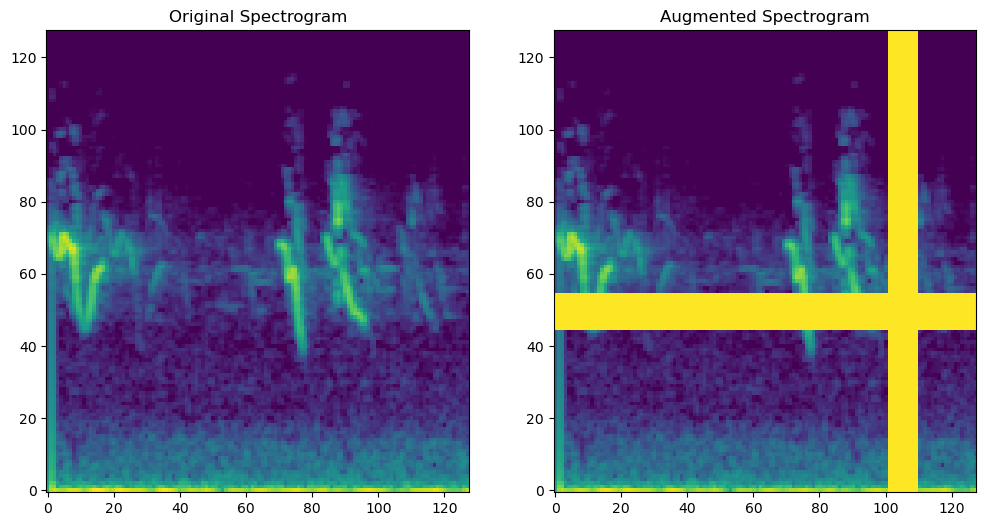

In [13]:
def visualize_augmentations(X):
    for spec in X[:1]:
        augmented_spec = apply_spec_augment(spec)

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Original Spectrogram")
        plt.imshow(spec, aspect='auto', origin='lower')

        plt.subplot(1, 2, 2)
        plt.title("Augmented Spectrogram")
        plt.imshow(augmented_spec, aspect='auto', origin='lower')

        plt.show()
# Example usage
visualize_augmentations(X_train)

## Collect And Display Metrics

In [9]:
def collect_metrics(X_train, y_train, X_val, y_val): #Figures, stats, dataframes, etc. showing the performance metrics:
    results = test_spec_augment_parameters(X_train, y_train, X_val, y_val)
    df = pd.DataFrame(results, columns=['Time Mask', 'Freq Mask', 'Accuracy'])
    return df

# Example usage to collect and display metrics
metrics_df = collect_metrics(X_train, y_train, X_val, y_val)
print(metrics_df)

Testing parameters: time_mask_val=10, freq_mask_val=10
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.0619 - loss: 84.6649 - val_accuracy: 0.0829 - val_loss: 4.6721
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.0920 - loss: 4.6491 - val_accuracy: 0.0829 - val_loss: 4.5805
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.0723 - loss: 5.0506 - val_accuracy: 0.0829 - val_loss: 4.4975
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.0883 - loss: 4.4812 - val_accuracy: 0.0829 - val_loss: 4.4222
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.0804 - loss: 4.4049 - val_accuracy: 0.0829 - val_loss: 4.3557
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.0912 - loss: 4.3441 - val_accuracy: 0.0829 - val_loss: 4.2973
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.0875 - loss: 4.2877 - val_accuracy: 0.0829 - val_loss: 4.2454
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━